In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
 
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
 
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
 
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
 
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
 
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


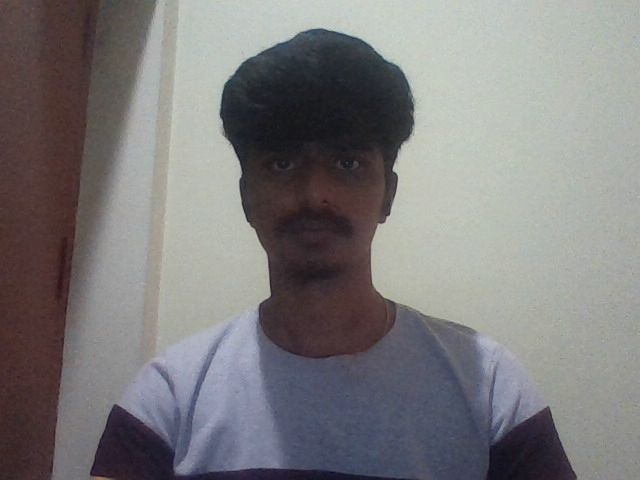

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

found 0 faces!
round shape


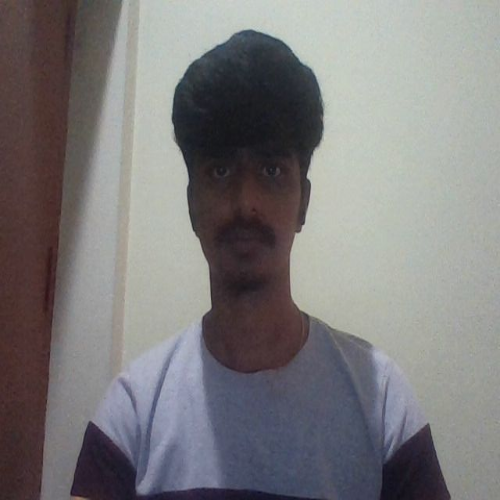

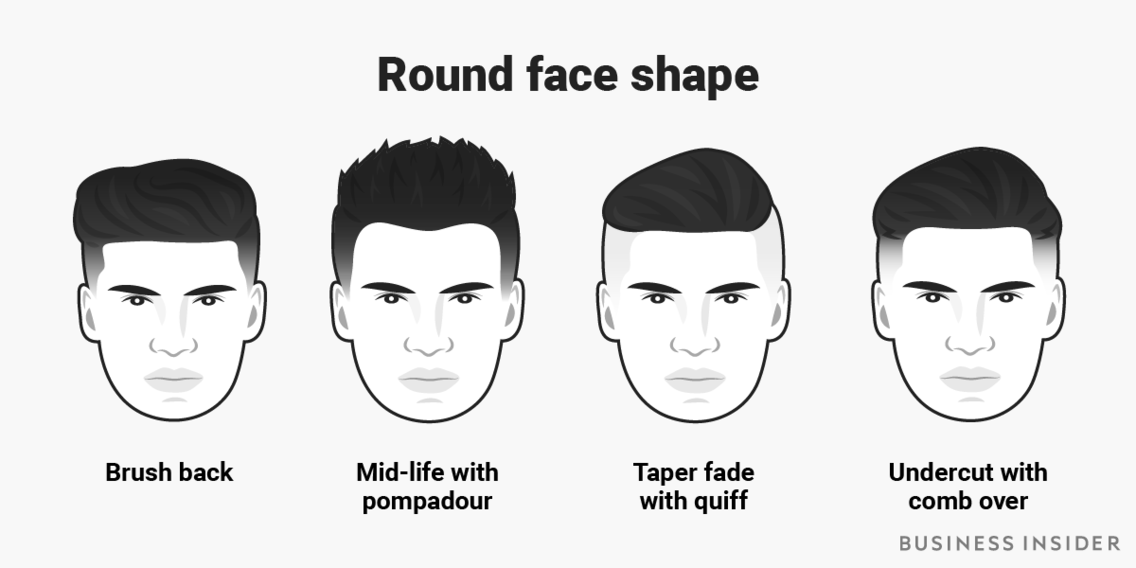

In [ ]:
#importing the libraries
import numpy as np #for mathematical calculations
import cv2 #for face detection and other image operations
import dlib #for detection of facial landmarks ex:nose,jawline,eyes
from sklearn.cluster import KMeans #for clustering|
from google.colab.patches import cv2_imshow

#load the image
imagepath = "/content/photo.jpg"
#haarcascade for detecting faces
# link = https://github.com/opencv/opencv/tree/master/data/haarcascades
face_cascade_path = "/content/drive/MyDrive/Face landmark detection/haarcascade_frontalface_default.xml"
#.dat file for detecting facial landmarks
#download file path = http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_path = "/content/drive/MyDrive/Face landmark detection/shape_predictor_68_face_landmarks.dat"
#create the haar cascade for detecting face and smile
faceCascade = cv2.CascadeClassifier(face_cascade_path)

#create the landmark predictor
predictor = dlib.shape_predictor(predictor_path)

#read the image
image = cv2.imread(imagepath)

#resizing the image to 000 cols nd 500 rows
image = cv2.resize(image, (500, 500)) 
#making another copy
original = image.copy()

#convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#apply a Gaussian blur with a 3 x 3 kernel to help remove high frequency noise
gauss = cv2.GaussianBlur(gray,(3,3), 0)

#Detect faces in the image
faces = faceCascade.detectMultiScale(
    gauss,
    scaleFactor=1.05,
    minNeighbors=5,
    minSize=(100,100),
    flags=cv2.CASCADE_SCALE_IMAGE
    )
#Detect faces in the image
print("found {0} faces!".format(len(faces)) )

for (x,y,w,h) in faces:
    #draw a rectangle around the faces
    cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)
    #converting the opencv rectangle coordinates to Dlib rectangle
    dlib_rect = dlib.rectangle(int(x), int(y), int(x+w), int(y+h))
    #detecting landmarks
    detected_landmarks = predictor(image, dlib_rect).parts()
    #converting to np matrix
    landmarks = np.matrix([[p.x,p.y] for p in detected_landmarks])
    #landmarks array contains indices of landmarks.
#making another copy  for showing final results
results = original.copy()

for (x,y,w,h) in faces:
    #draw a rectangle around the faces
    cv2.rectangle(results, (x,y), (x+w,y+h), (0,255,0), 2)
    #making temporary copy
    temp = original.copy()
    #getting area of interest from image i.e., forehead (25% of face)
    forehead = temp[y:y+int(0.25*h), x:x+w]
    rows,cols, bands = forehead.shape
    X = forehead.reshape(rows*cols,bands)
    #kmeans
    kmeans = KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10, random_state=0)
    y_kmeans = kmeans.fit_predict(X)
    for i in range(0,rows):
        for j in range(0,cols):
            if y_kmeans[i*cols+j]==True:
                forehead[i][j]=[255,255,255]
            if y_kmeans[i*cols+j]==False:
                forehead[i][j]=[0,0,0]
    #Steps to get the length of forehead
    #1.get midpoint of the forehead
    #2.travel left side and right side
    #the idea here is to detect the corners of forehead which is the hair.
    #3.Consider the point which has change in pixel value (which is hair)
    forehead_mid = [int(cols/2), int(rows/2) ] #midpoint of forehead
    lef=0 
    #gets the value of forehead point
    pixel_value = forehead[forehead_mid[1],forehead_mid[0] ]
    for i in range(0,cols):
        #enters if when change in pixel color is detected
        if forehead[forehead_mid[1],forehead_mid[0]-i].all()!=pixel_value.all():
            lef=forehead_mid[0]-i
            break;
    left = [lef,forehead_mid[1]]
    rig=0
    for i in range(0,cols):
        #enters if when change in pixel color is detected
        if forehead[forehead_mid[1],forehead_mid[0]+i].all()!=pixel_value.all():
            rig = forehead_mid[0]+i
            break;
    right = [rig,forehead_mid[1]]
    
#drawing line1 on forehead with circles
#specific landmarks are used. 
line1 = np.subtract(right+y,left+x)[0]
cv2.line(results, tuple(x+left), tuple(y+right), color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 1',tuple(x+left),fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, tuple(x+left), 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, tuple(y+right), 5, color=(255,0,0), thickness=-1)        

#drawing line 2 with circles
linepointleft = (landmarks[1,0],landmarks[1,1])
linepointright = (landmarks[15,0],landmarks[15,1])
line2 = np.subtract(linepointright,linepointleft)[0]
cv2.line(results, linepointleft,linepointright,color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 2',linepointleft,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, linepointleft, 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, linepointright, 5, color=(255,0,0), thickness=-1)    

#drawing line 3 with circles
linepointleft = (landmarks[3,0],landmarks[3,1])
linepointright = (landmarks[13,0],landmarks[13,1])
line3 = np.subtract(linepointright,linepointleft)[0]
cv2.line(results, linepointleft,linepointright,color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 3',linepointleft,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, linepointleft, 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, linepointright, 5, color=(255,0,0), thickness=-1)    

#drawing line 4 with circles
linepointbottom = (landmarks[8,0],landmarks[8,1])
linepointtop = (landmarks[8,0],y)
line4 = np.subtract(linepointbottom,linepointtop)[1]
cv2.line(results,linepointtop,linepointbottom,color=(0,255,0), thickness = 2)
cv2.putText(results,' Line 4',linepointbottom,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,255,0), thickness=2)
cv2.circle(results, linepointtop, 5, color=(255,0,0), thickness=-1)    
cv2.circle(results, linepointbottom, 5, color=(255,0,0), thickness=-1)    
#print(line1,line2,line3,line4)

similarity = np.std([line1,line2,line3])
#print("similarity=",similarity)
ovalsimilarity = np.std([line2,line4])
#print('diam=',ovalsimilarity)

#we use arcustangens for angle calculation
ax,ay = landmarks[3,0],landmarks[3,1]
bx,by = landmarks[4,0],landmarks[4,1]
cx,cy = landmarks[5,0],landmarks[5,1]
dx,dy = landmarks[6,0],landmarks[6,1]
import math
from math import degrees
alpha0 = math.atan2(cy-ay,cx-ax)
alpha1 = math.atan2(dy-by,dx-bx)
alpha = alpha1-alpha0
angle = abs(degrees(alpha))
angle = 180-angle

for i in range(1):
  if similarity<10:
    if angle<160:
      print('squared shape')
      img="/content/drive/MyDrive/58502239a1a45e8b3f8b47c4.jfif"
      img=cv2.imread(img)
      cv2_imshow(original)
      cv2_imshow(img)
      
      break
    else:
      print('round shape')
      img="/content/drive/MyDrive/styles/round.png"
      img=cv2.imread(img)
      cv2_imshow(original)
      cv2_imshow(img)
      break
  if line3>line1:
    if angle<160:
      print('triangle shape') 
      img="/content/drive/MyDrive/styles/triangle.png"
      img=cv2.imread(img)
      cv2_imshow(original)
      cv2_imshow(img)
      break
  if ovalsimilarity<10:
    print('diamond shape')
    img="/content/drive/MyDrive/styles/diamond.PNG"
    img=cv2.imread(img)
    cv2_imshow(original)
    cv2_imshow(img)
    break
  if line4 > line2:
    if angle<160:
      print('rectangular')
      img="/content/drive/MyDrive/styles/rectangle.png"
      img=cv2.imread(img)
      cv2_imshow(original)
      cv2_imshow(img)
      break;
    else:
      print('Long')
      img="/content/drive/MyDrive/styles/long.jfif"
      img=cv2.imread(img)
      cv2_imshow(original)
      cv2_imshow(img)
      break;

